
## Project: Write an Algorithm for Bengali Alphabet Recognition App 


---
### Overview 

In this notebook, we will be developing an algorithm that could be used for recognition of handwritten Bengali alphabets. There are 50 basic bengali alphabets; 11 vowels and 39 consonants.


### Import Bengali Alphabet Dataset

In the code cell below, we import a dataset of bengali character images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `alphabets` - numerical representations of the 50 Bengali alphabets from 0 to 49

In [31]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# define function to load train and test datasets 
# the function returns 3 numpy arrays with filenames, one-hot-encoded values and raw outputs
def load_dataset(path):
    data = load_files(path)
    alphabet_files = np.array(data['filenames'])
    targets = np.array(data['target'])
    alphabet_targets = np_utils.to_categorical(targets, 50)
    
    return alphabet_files, alphabet_targets, targets

# load train and test datasets
train_files, train_targets, raw_train_targets = load_dataset('BasicFinalDatabase/Train')
test_files, test_targets, raw_test_targets = load_dataset('BasicFinalDatabase/Test')

# load list of characters
alphabets = [item[25:-1] for item in sorted(glob("BasicFinalDatabase/Train/*/"))]

# print statistics about the dataset
print('There are %d total alphabets' % len(alphabets))
print('There are %s total alphabet images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training alphabet images.' % len(train_files))
print('There are %d test alphabet images.'% len(test_files))


There are 50 total alphabets
There are 15000 total alphabet images.

There are 12000 training alphabet images.
There are 3000 test alphabet images.


### Analyze the Dataset

In the code cell below, we analyze the dataset using some statistical tools

Distribution of the training data in the dataset


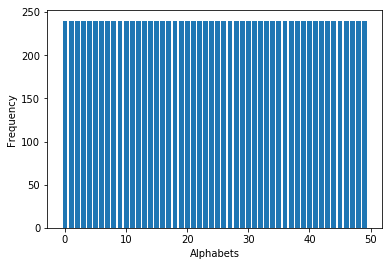

Distribution of the test data in the dataset


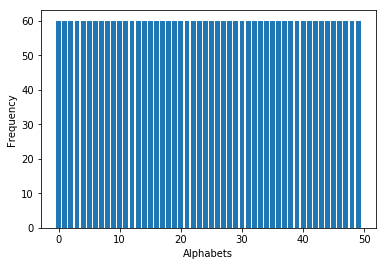

In [32]:
# Function to display the distribution of data in the training and test sets by alphabet classes
def plot_dist(target_set):
    plt.figure(figsize=(6,4))
    labels, values = zip(*target_set.items())
    #indexes = np.arange(len(labels))
    width = 0.8
    plt.bar(labels, values, width)
    plt.xlabel('Alphabets')
    plt.ylabel('Frequency')
    plt.show()

print('Distribution of the training data in the dataset')    
plot_dist(Counter(raw_train_targets))
print('Distribution of the test data in the dataset') 
plot_dist(Counter(raw_test_targets))

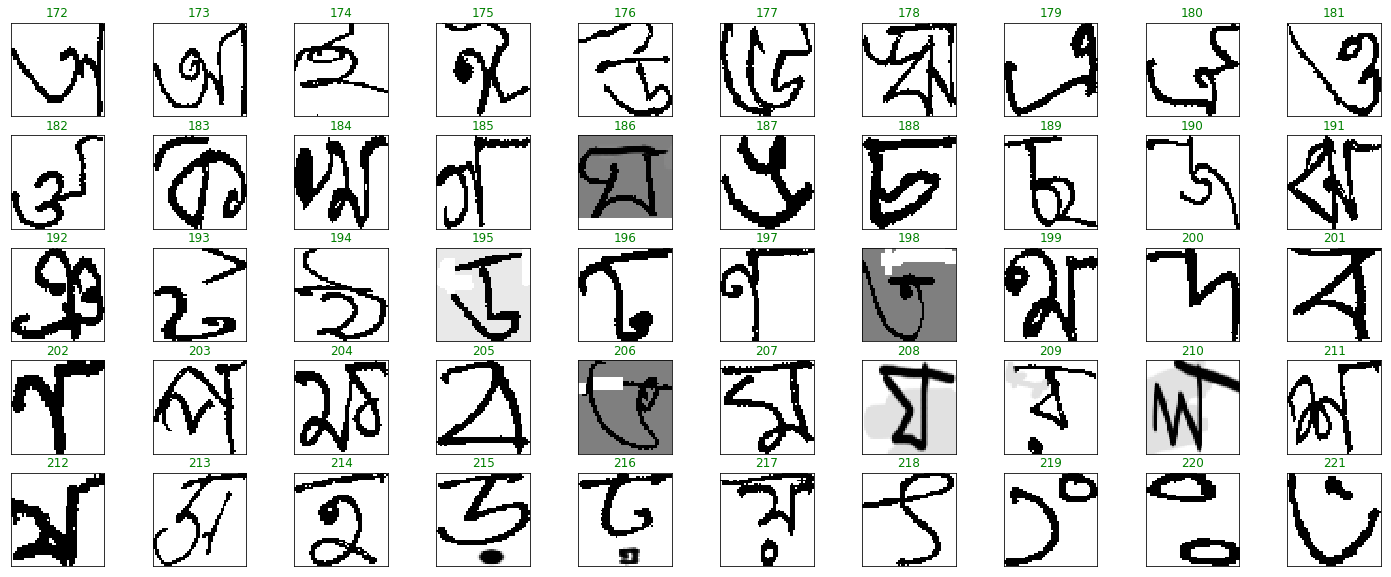

In [33]:
#Show sample images 
from keras.preprocessing import image                  
from keras.preprocessing.image import img_to_array, load_img
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

#Scan through the training dataset to pick up one random character each folder
alphabet_folders = sorted(glob("BasicFinalDatabase/Train/*/"))
sample_files = []
for folder in alphabet_folders:
    sample_files.append(glob(folder + "*.bmp")[np.random.randint(0,49)])
sample_files = np.array(sample_files)

#Display the characters
fig = plt.figure(figsize=(25,10))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(load_img(sample_files[i], target_size=(50,50), grayscale=True)), cmap = 'gray')
    ax.set_title("{}".format(alphabets[i]),
                 color="green")

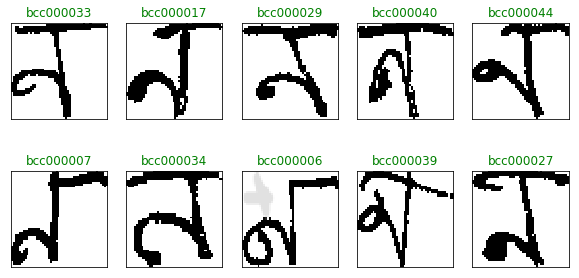

In [34]:
#View random characters in folders
sample_files = []
folder = 'BasicFinalDatabase/Train/202/'
for i in range(10):    
    sample_files.append(glob(folder + "*.bmp")[np.random.randint(0, 49)])

sample_files = np.array(sample_files)

fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(load_img(sample_files[i], target_size=(50,50), grayscale=True)), cmap = 'gray')
    ax.set_title("{}".format(sample_files[i][29:-4]),
                 color="green")

There are 50 total alphabets
There are 15000 total alphabet images.

There are 9600 training alphabet images.
There are 2400 validation alphabet images.
There are 3000 test alphabet images.

Distribution of the validation data in the dataset


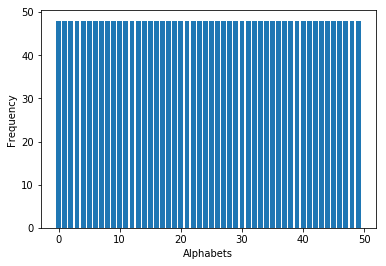

In [35]:
# Splitting the Training set into the Training set and Validation set
from sklearn.model_selection import train_test_split
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size = 0.2, random_state = 0, stratify = raw_train_targets)

# print statistics about the dataset post split
print('There are %d total alphabets' % len(alphabets))
print('There are %s total alphabet images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training alphabet images.' % len(train_files))
print('There are %d validation alphabet images.' % len(valid_files))
print('There are %d test alphabet images.\n'% len(test_files))

# Show distribution of data in validation set
raw_valid_targets = []
for i in range(len(valid_targets)):
    raw_valid_targets.append(np.argmax(valid_targets[i]))
    
raw_valid_targets = np.array(raw_valid_targets)
print('Distribution of the validation data in the dataset')  
plot_dist(Counter(raw_valid_targets))

### Visualize the First 36 Validation Images

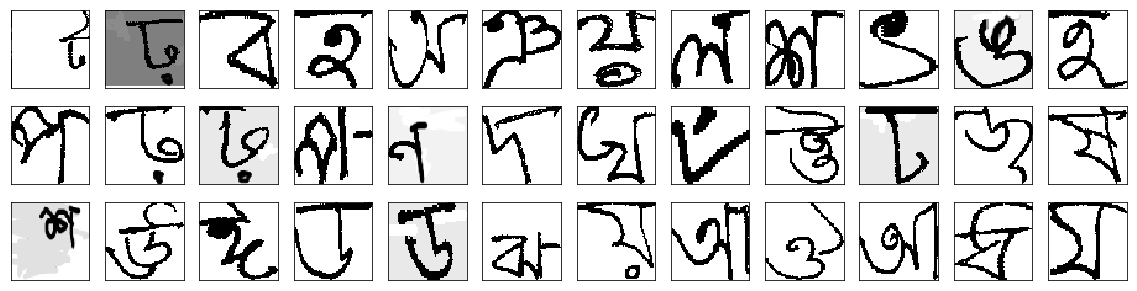

In [36]:
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(load_img(valid_files[i], target_size=(64,64), grayscale=True)), cmap = 'gray')

### Prepare the Training, Validation and Test Datasets

In the code cell below, we prepare the training, validation and test datasets for CNN in Keras.

In [37]:
### Prepare the Training, Validation and Test Datasets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(64, 64), grayscale=True)
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras. We rescale the images by dividing every pixel in every image by 255. 
# So the scale is now 0-1 instead of 0-255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

# print number of training, validation, and test images
print(train_tensors.shape[0], 'train samples')
print(valid_tensors.shape[0], 'valid samples')
print(test_tensors.shape[0], 'test samples')

9600 train samples
2400 valid samples
3000 test samples


### Benchmark Architecture

Build a simple CNN model with 2 convolutional layers using relu activation and 1 fully connected layer terminating in 50 softmax classifiers.

In [23]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

# Initialising the CNN
model = Sequential()

# First Convolution Layer with Pooling
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(train_tensors.shape[1:])))
model.add(MaxPooling2D(pool_size=2))

# Adding a second convolutional layer with Pooling
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size =2))

model.add(GlobalAveragePooling2D())

# Full connection Dense Layers
model.add(Dense(50, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1650      
Total params: 3,938
Trainable params: 3,938
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Accuracy with random prediction is expected to be 1 in 50 so roughly 2%
alphabet_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(alphabet_predictions)==np.argmax(test_targets, axis=1))/len(alphabet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.0000%


### Train the Model

The benchmark model is trained below.  Used model checkpointing to save the model that attains the best validation loss.

In [27]:
### Train the model and save the weights for the best one
from keras.callbacks import ModelCheckpoint  

#specify the number of epochs that you would like to use to train the model.

epochs = 100
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_simplebm.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
9600/9600 [==============================] - 33s - loss: 2.9329 - acc: 0.1831 - val_loss: 2.9168 - val_acc: 0.2071
Epoch 2/100
9600/9600 [==============================] - 32s - loss: 2.9157 - acc: 0.1953 - val_loss: 2.9017 - val_acc: 0.2067
Epoch 3/100
9600/9600 [==============================] - 31s - loss: 2.9024 - acc: 0.1909 - val_loss: 2.9038 - val_acc: 0.1938
Epoch 4/100
9600/9600 [==============================] - 31s - loss: 2.8896 - acc: 0.1949 - val_loss: 2.8843 - val_acc: 0.2092
Epoch 5/100
9600/9600 [==============================] - 31s - loss: 2.8740 - acc: 0.1981 - val_loss: 2.9063 - val_acc: 0.2071
Epoch 6/100
9600/9600 [==============================] - 31s - loss: 2.8615 - acc: 0.2027 - val_loss: 2.8573 - val_acc: 0.2096
Epoch 7/100
9600/9600 [==============================] - 31s - loss: 2.8497 - acc: 0.2096 - val_loss: 2.8439 - val_acc: 0.2179
Epoch 8/100
9600/9600 [==============================] - 31s - 

9600/9600 [==============================] - 31s - loss: 2.6464 - acc: 0.2525 - val_loss: 2.6652 - val_acc: 0.2525
Epoch 28/100
9600/9600 [==============================] - 29s - loss: 2.6390 - acc: 0.2550 - val_loss: 2.6401 - val_acc: 0.2642
Epoch 29/100
9600/9600 [==============================] - 29s - loss: 2.6309 - acc: 0.2541 - val_loss: 2.6590 - val_acc: 0.2500
Epoch 30/100
9600/9600 [==============================] - 29s - loss: 2.6239 - acc: 0.2537 - val_loss: 2.6389 - val_acc: 0.2517
Epoch 31/100
9600/9600 [==============================] - 29s - loss: 2.6169 - acc: 0.2577 - val_loss: 2.6173 - val_acc: 0.2646
Epoch 32/100
9600/9600 [==============================] - 29s - loss: 2.6093 - acc: 0.2624 - val_loss: 2.6249 - val_acc: 0.2450
Epoch 33/100
9600/9600 [==============================] - 30s - loss: 2.6043 - acc: 0.2586 - val_loss: 2.6004 - val_acc: 0.2679
Epoch 34/100
9600/9600 [==============================] - 29s - loss: 2.5928 - acc: 0.2655 - val_loss: 2.6062 - val_a

9600/9600 [==============================] - 39s - loss: 2.4689 - acc: 0.2895 - val_loss: 2.5183 - val_acc: 0.2792
Epoch 57/100
9600/9600 [==============================] - 31s - loss: 2.4630 - acc: 0.2909 - val_loss: 2.5345 - val_acc: 0.2729
Epoch 58/100
9600/9600 [==============================] - 34s - loss: 2.4594 - acc: 0.2964 - val_loss: 2.4956 - val_acc: 0.2833
Epoch 59/100
9600/9600 [==============================] - 31s - loss: 2.4510 - acc: 0.2942 - val_loss: 2.4797 - val_acc: 0.2963
Epoch 60/100
9600/9600 [==============================] - 31s - loss: 2.4462 - acc: 0.2997 - val_loss: 2.4812 - val_acc: 0.2992
Epoch 61/100
9600/9600 [==============================] - 30s - loss: 2.4455 - acc: 0.2992 - val_loss: 2.4597 - val_acc: 0.3038
Epoch 62/100
9600/9600 [==============================] - 32s - loss: 2.4390 - acc: 0.2986 - val_loss: 2.4926 - val_acc: 0.2963
Epoch 63/100
9600/9600 [==============================] - 34s - loss: 2.4370 - acc: 0.2993 - val_loss: 2.4533 - val_a

9600/9600 [==============================] - 31s - loss: 2.3456 - acc: 0.3196 - val_loss: 2.4164 - val_acc: 0.2833
Epoch 87/100
9600/9600 [==============================] - 30s - loss: 2.3424 - acc: 0.3228 - val_loss: 2.3896 - val_acc: 0.3046
Epoch 88/100
9600/9600 [==============================] - 30s - loss: 2.3376 - acc: 0.3204 - val_loss: 2.4100 - val_acc: 0.3067
Epoch 89/100
9600/9600 [==============================] - 30s - loss: 2.3383 - acc: 0.3227 - val_loss: 2.3769 - val_acc: 0.3217
Epoch 90/100
9600/9600 [==============================] - 30s - loss: 2.3310 - acc: 0.3255 - val_loss: 2.3774 - val_acc: 0.3183
Epoch 91/100
9600/9600 [==============================] - 28s - loss: 2.3283 - acc: 0.3223 - val_loss: 2.3912 - val_acc: 0.3096
Epoch 92/100
9600/9600 [==============================] - 28s - loss: 2.3231 - acc: 0.3310 - val_loss: 2.3588 - val_acc: 0.3179
Epoch 93/100
9600/9600 [==============================] - 28s - loss: 2.3198 - acc: 0.3294 - val_loss: 2.3797 - val_a

### Test the Benchmark Model

In [30]:
# get index of predicted alphabetnfor each image in test set
alphabet_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
from sklearn import metrics
y_true = [np.argmax(y_test) for y_test in test_targets]
f1_accuracy = 100* metrics.f1_score(y_true,alphabet_predictions, average = 'micro')
print('Test F1 accuracy: %.4f%%' % f1_accuracy)

Test F1 accuracy: 32.5667%


### Best Model
Build the best model as per experiments and further fine tune

In [38]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense


# Initialising the CNN
model = Sequential()

# First Convolution Layer with Pooling
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(train_tensors.shape[1:])))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Adding a second convolutional layer with Pooling
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.2))

# Adding a third convolutional layer with Pooling
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.2))

# Adding a fourth convolutional layer with Pooling
model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.2))


# Adding a fifth convolutional layer with Pooling
model.add(Conv2D(filters=256, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.2))



#model.add(GlobalAveragePooling2D())
model.add(Flatten())

# Full connection Dense Layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'softmax'))

model.summary()


### Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 63, 16)        80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        8256      
__________

### Train the model 

In [43]:
### Train the model and save the weights for the best one
from keras.callbacks import ModelCheckpoint  

#specify the number of epochs that you would like to use to train the model.

epochs = 100
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_deepcnnwithDO.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
9600/9600 [==============================] - 52s - loss: 0.2108 - acc: 0.9356 - val_loss: 0.1576 - val_acc: 0.9550
Epoch 2/100
9600/9600 [==============================] - 53s - loss: 0.2500 - acc: 0.9298 - val_loss: 0.1883 - val_acc: 0.9417
Epoch 3/100
9600/9600 [==============================] - 47s - loss: 0.2398 - acc: 0.9339 - val_loss: 0.1789 - val_acc: 0.9492
Epoch 4/100
9600/9600 [==============================] - 48s - loss: 0.2188 - acc: 0.9403 - val_loss: 0.1696 - val_acc: 0.9496
Epoch 5/100
9600/9600 [==============================] - 51s - loss: 0.2240 - acc: 0.9384 - val_loss: 0.1495 - val_acc: 0.9683
Epoch 6/100
9600/9600 [==============================] - 48s - loss: 0.2314 - acc: 0.9410 - val_loss: 0.1827 - val_acc: 0.9529
Epoch 7/100
9600/9600 [==============================] - 48s - loss: 0.2407 - acc: 0.9378 - val_loss: 0.1537 - val_acc: 0.9613
Epoch 8/100
9600/9600 [==============================] - 51s - 

9600/9600 [==============================] - 51s - loss: 0.3027 - acc: 0.9389 - val_loss: 0.2069 - val_acc: 0.9525
Epoch 34/100
9600/9600 [==============================] - 50s - loss: 0.2557 - acc: 0.9422 - val_loss: 0.2187 - val_acc: 0.9479
Epoch 35/100
9600/9600 [==============================] - 54s - loss: 0.3076 - acc: 0.9429 - val_loss: 0.2258 - val_acc: 0.9421
Epoch 36/100
9600/9600 [==============================] - 53s - loss: 0.2795 - acc: 0.9410 - val_loss: 0.2308 - val_acc: 0.9371
Epoch 37/100
9600/9600 [==============================] - 52s - loss: 0.2714 - acc: 0.9399 - val_loss: 0.2550 - val_acc: 0.9437
Epoch 38/100
9600/9600 [==============================] - 53s - loss: 0.2873 - acc: 0.9418 - val_loss: 0.2568 - val_acc: 0.9337
Epoch 39/100
9600/9600 [==============================] - 51s - loss: 0.3013 - acc: 0.9402 - val_loss: 0.2145 - val_acc: 0.9508
Epoch 40/100
9600/9600 [==============================] - 53s - loss: 0.2918 - acc: 0.9410 - val_loss: 0.3336 - val_a

9600/9600 [==============================] - 46s - loss: 0.2801 - acc: 0.9372 - val_loss: 0.2245 - val_acc: 0.9425
Epoch 67/100
9600/9600 [==============================] - 46s - loss: 0.3373 - acc: 0.9346 - val_loss: 0.2424 - val_acc: 0.9396
Epoch 68/100
9600/9600 [==============================] - 46s - loss: 0.2979 - acc: 0.9426 - val_loss: 0.2755 - val_acc: 0.9329
Epoch 69/100
9600/9600 [==============================] - 46s - loss: 0.3036 - acc: 0.9394 - val_loss: 0.2885 - val_acc: 0.9429
Epoch 70/100
9600/9600 [==============================] - 46s - loss: 0.2973 - acc: 0.9401 - val_loss: 0.2939 - val_acc: 0.9279
Epoch 71/100
9600/9600 [==============================] - 45s - loss: 0.2867 - acc: 0.9376 - val_loss: 0.3112 - val_acc: 0.9233
Epoch 72/100
9600/9600 [==============================] - 46s - loss: 0.3285 - acc: 0.9374 - val_loss: 0.2716 - val_acc: 0.9246
Epoch 73/100
9600/9600 [==============================] - 45s - loss: 0.3145 - acc: 0.9372 - val_loss: 0.2773 - val_a

9600/9600 [==============================] - 45s - loss: 0.3116 - acc: 0.9397 - val_loss: 0.2314 - val_acc: 0.9496
Epoch 100/100
9600/9600 [==============================] - 45s - loss: 0.3566 - acc: 0.9359 - val_loss: 0.2642 - val_acc: 0.9367


### Load the Model with the Best Validation Loss

In [44]:
model.load_weights('saved_models/weights.best.from_deepcnnwithDO.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [45]:
# get index of predicted alphabetnfor each image in test set
alphabet_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

from sklearn import metrics
y_true = [np.argmax(y_test) for y_test in test_targets]
f1_accuracy = 100* metrics.f1_score(y_true,alphabet_predictions, average = 'micro')
print('Test F1 accuracy: %.4f%%' % f1_accuracy)

Test F1 accuracy: 95.9333%


### Train and test the Best model with augmented data

In [ ]:
# Augment the training data 
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    rotation_range=15, 
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest') # randomly rotate images by 15 degrees

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    rotation_range=15, 
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

from keras.callbacks import ModelCheckpoint   

batch_size = 256
epochs = 500

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.with_augmentation_new.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

In [40]:
#load the model with best weights
model.load_weights('saved_models/weights.best.with_augmentation_new.hdf5')
#model.load_weights('saved_models/weights.best.with_augmentation.hdf5')
# get index of predicted alphabetnfor each image in test set
alphabet_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

from sklearn import metrics
y_true = [np.argmax(y_test) for y_test in test_targets]
f1_accuracy = 100* metrics.f1_score(y_true,alphabet_predictions, average = 'micro')
print('Test F1 accuracy: %.4f%%' % f1_accuracy)

Test F1 accuracy: 96.3333%


### Visualizations and Error Analysis
This may give you some insight into why the network is misclassifying certain objects.

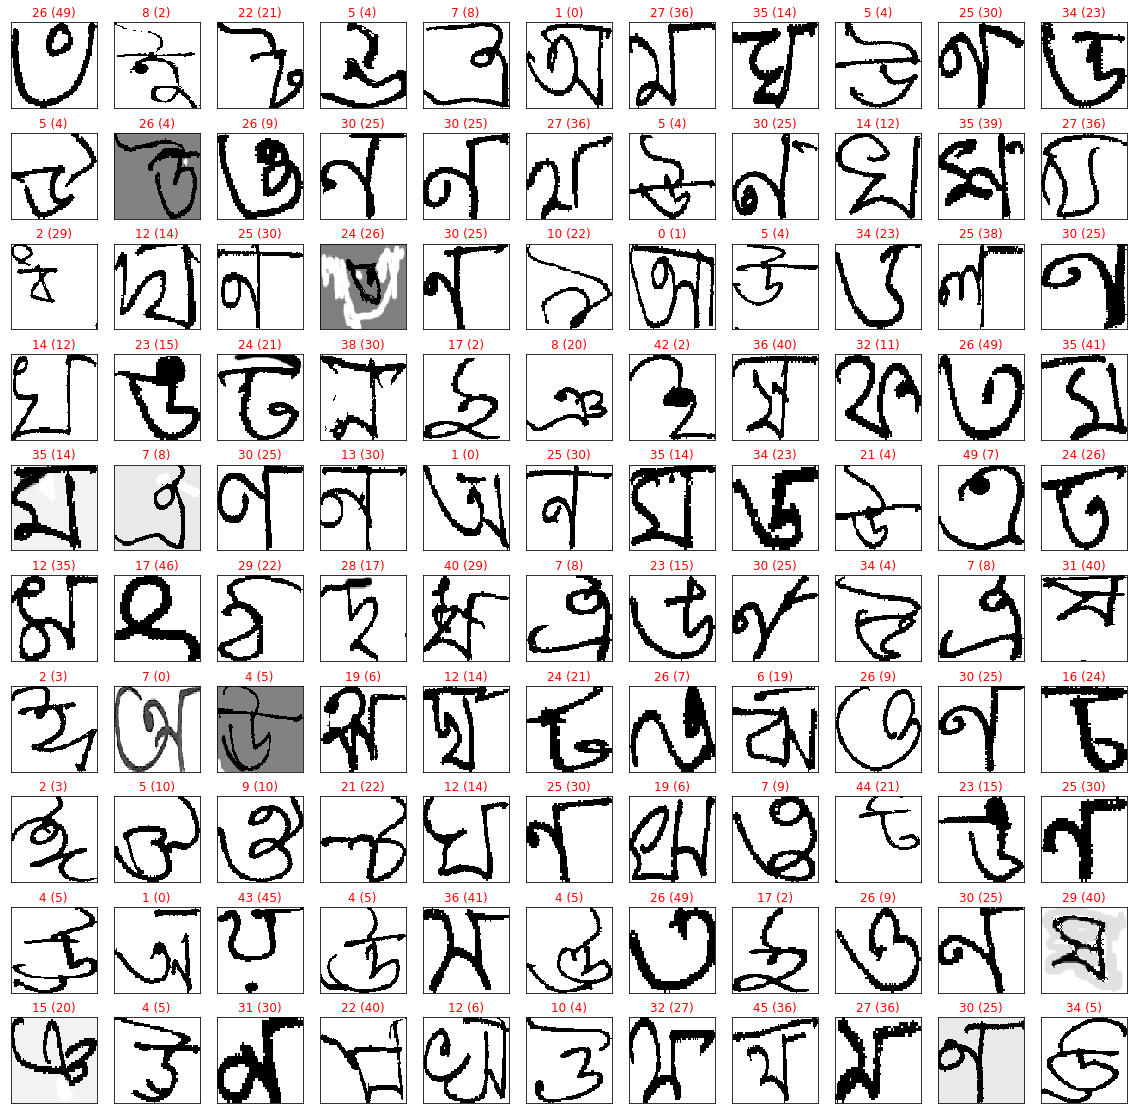

In [42]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_true, alphabet_predictions)

### Error Analysis
## Find all the test cases where the prediction does not match the actual.
## Trace back to file names and analyse 
## Loop over test tensors, predict and if doesnt match with actual add the file
## name to an array

error_files = []
error_images = []
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=3000, replace=False)):
    pred_idx = alphabet_predictions[idx]
    true_idx = np.argmax(test_targets[idx])
    if pred_idx != true_idx:
         error_files.append(test_files[idx])
         error_images.append(idx)

error_files = np.array(error_files) 
error_images = np.array(error_images) 
errors=np.stack((error_images,error_files),axis=-1)
         

fig = plt.figure(figsize=(20,20))
i = 0 
for idx, pic in errors:
    idx = int(idx)
    ax = fig.add_subplot(10, 11, i + 1, xticks=[], yticks=[])
    
    #print ('Misclassified the file: ' + pic + ' As: ' + str (alphabet_predictions[idx] ) + ' instead of ' + str(np.argmax(test_targets[idx])) + ' Index: ' + str(idx))

    ax.imshow(np.squeeze(load_img(pic, target_size=(100,100), grayscale=True)), cmap = 'gray')
    ax.set_title("{} ({})".format(str (alphabet_predictions[idx] ), str(np.argmax(test_targets[idx]))),
                 color=("red"))
    i += 1